Lab 3
Global tragectory planning

Author: Mohamad Rua

Isu num. 408051

=== Potential Field Path Planning ===
Start: [0.0, 0.0]
Goal: [8.0, 8.0]
Obstacles: [[2.0, 3.0], [4.0, 4.0], [5.0, 7.0], [7.0, 5.0]]

Planning path...
Goal reached successfully!

Path computed with 117 points
Final position: [8. 8.]
Distance to goal: 0.0000

Generating visualization...


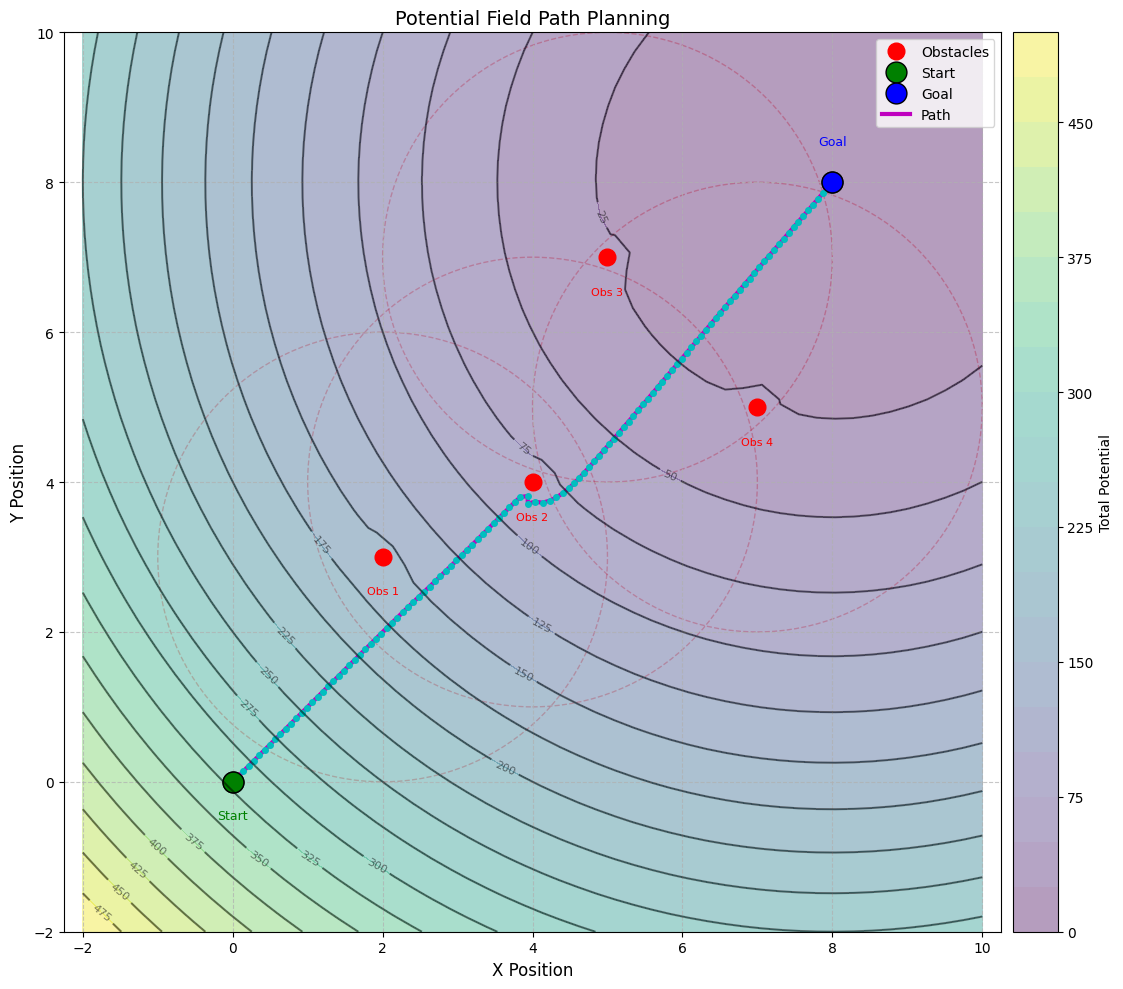

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class PotentialFieldPlanner:
    def __init__(self, start, goal, obstacles, step_size=0.1, max_iters=5000, goal_tol=0.1):
        """
        Initialize the path planner with start, goal, obstacles, and parameters

        Args:
            start: Starting position [x, y]
            goal: Goal position [x, y]
            obstacles: List of obstacle positions [[x1, y1], [x2, y2], ...]
            step_size: Distance to move in each iteration (learning rate)
            max_iters: Maximum number of iterations to prevent infinite loops
            goal_tol: Distance threshold to consider goal reached
        """
        # Convert positions to NumPy arrays for vector operations
        self.start = np.array(start, dtype=float)
        self.goal = np.array(goal, dtype=float)
        self.obstacles = [np.array(obs) for obs in obstacles]

        # Algorithm parameters
        self.step_size = step_size
        self.max_iters = max_iters
        self.goal_tol = goal_tol

        # Potential field gains (tuned for obstacle navigation)
        self.att_gain = 5.0    # Strength of attraction to goal
        self.rep_gain = 0.5     # Strength of repulsion from obstacles
        self.rep_range = 3.0    # Maximum distance at which obstacles exert repulsion

    def attractive_potential(self, position):
        """
        Compute attractive potential and its gradient (force pulling robot toward goal)

        Implements hybrid potential:
        - Quadratic potential at long distances (strong pull)
        - Linear potential near goal (prevents oscillations)

        Args:
            position: Current robot position [x, y]

        Returns:
            potential: Attractive potential value
            gradient: Gradient vector (direction to move toward goal)
        """
        # Calculate vector to goal and its magnitude
        vec_to_goal = self.goal - position
        dist = np.linalg.norm(vec_to_goal)

        # Distance threshold for switching potential functions
        switch_dist = 2.0

        if dist > switch_dist:
            # Quadratic potential: U_att = 0.5 * k_att * dist^2
            potential = 0.5 * self.att_gain * dist**2

            # Gradient: ∇U_att = k_att * (goal - position)
            gradient = self.att_gain * vec_to_goal
        else:
            # Linear potential: U_att = k_att * d0 * dist
            potential = self.att_gain * switch_dist * dist

            # Gradient: ∇U_att = k_att * d0 * unit_vector(goal - position)
            if dist < 1e-6:  # Avoid division by zero
                gradient = np.zeros_like(vec_to_goal)
            else:
                gradient = self.att_gain * switch_dist * (vec_to_goal / dist)

        return potential, gradient

    def repulsive_potential(self, position):
        """
        Compute repulsive potential and gradient (force pushing robot away from obstacles)

        Args:
            position: Current robot position [x, y]

        Returns:
            total_potential: Sum of repulsive potentials from all obstacles
            total_gradient: Sum of repulsive gradients from all obstacles
        """
        total_potential = 0.0
        total_gradient = np.zeros_like(position)  # Initialize gradient vector

        for obs in self.obstacles:
            # Calculate vector to obstacle and distance
            vec_to_obs = position - obs
            dist = np.linalg.norm(vec_to_obs)

            # Only consider obstacles within influence range
            if dist < self.rep_range:
                # Handle very small distances to avoid division by zero
                if dist < 1e-6:
                    dist = 1e-6

                # Calculate inverse distance
                inv_dist = 1.0 / dist

                # Repulsive potential:
                # U_rep = 0.5 * k_rep * (1/dist - 1/rep_range)^2
                potential = 0.5 * self.rep_gain * (inv_dist - 1/self.rep_range)**2

                # Repulsive gradient (negative gradient of potential):
                # ∇U_rep = k_rep * (1/dist - 1/rep_range) * (1/dist^3) * (position - obstacle)
                grad_mag = self.rep_gain * (inv_dist - 1/self.rep_range) * inv_dist**3
                gradient = grad_mag * vec_to_obs

                # Accumulate potentials and gradients from all obstacles
                total_potential += potential
                total_gradient += gradient

        return total_potential, total_gradient

    def total_potential(self, position):
        """
        Compute total potential and gradient at given position

        Args:
            position: Current robot position [x, y]

        Returns:
            total_U: Sum of attractive and repulsive potentials
            total_grad: Sum of attractive and repulsive gradients
        """
        # Calculate attractive components
        U_att, grad_att = self.attractive_potential(position)

        # Calculate repulsive components
        U_rep, grad_rep = self.repulsive_potential(position)

        # Combine results
        total_U = U_att + U_rep
        total_grad = grad_att + grad_rep

        return total_U, total_grad

    def plan_path(self):
        """
        Plan path from start to goal using gradient descent

        Returns:
            path: List of positions from start to goal
        """
        # Initialize path with starting position
        path = [self.start.copy()]
        current_pos = self.start.copy()

        # Main planning loop
        for _ in range(self.max_iters):
            # Check if goal is reached (within tolerance)
            if np.linalg.norm(current_pos - self.goal) < self.goal_tol:
                path.append(self.goal.copy())  # Explicitly add goal position
                print("Goal reached successfully!")
                break

            # Compute total gradient at current position
            _, grad = self.total_potential(current_pos)
            grad_norm = np.linalg.norm(grad)

            # Normalize gradient to unit vector if non-zero
            if grad_norm > 1e-6:
                direction = grad / grad_norm
            else:
                # If gradient is near zero, add small random perturbation
                # to escape local minima
                direction = np.random.uniform(-0.5, 0.5, 2)
                direction = direction / np.linalg.norm(direction)
                print("Local minimum detected - applying perturbation")

            # Move in the direction of the gradient
            current_pos += self.step_size * direction

            # Add new position to path
            path.append(current_pos.copy())
        else:
            print(f"Warning: Maximum iterations ({self.max_iters}) reached before reaching goal")

        return np.array(path)

    def plot_results(self, path):
        """
        Visualize the planning results

        Args:
            path: Computed path from start to goal
        """
        plt.figure(figsize=(12, 10))

        # ===== Obstacle Visualization =====
        for i, obs in enumerate(self.obstacles):
            # Plot obstacles as red circles
            plt.plot(obs[0], obs[1], 'ro', markersize=12,
                     label='Obstacles' if i == 0 else "")

            # Add influence range rings
            circle = plt.Circle((obs[0], obs[1]), self.rep_range,
                               color='red', fill=False, alpha=0.3, linestyle='--')
            plt.gca().add_patch(circle)

        # ===== Start/Goal Visualization =====
        plt.plot(self.start[0], self.start[1], 'go', markersize=15,
                 label='Start', markeredgecolor='black')
        plt.plot(self.goal[0], self.goal[1], 'bo', markersize=15,
                 label='Goal', markeredgecolor='black')

        # ===== Path Visualization =====
        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'm-', linewidth=3, label='Path')
        plt.plot(path[:, 0], path[:, 1], 'c.', markersize=8)

        # Highlight start and goal on path
        plt.plot(path[0, 0], path[0, 1], 'go', markersize=15, markeredgecolor='black')
        plt.plot(path[-1, 0], path[-1, 1], 'bo', markersize=15, markeredgecolor='black')

        # ===== Potential Field Visualization =====
        # Create grid for potential field visualization
        x_vals = np.linspace(-2, 10, 50)
        y_vals = np.linspace(-2, 10, 50)
        X, Y = np.meshgrid(x_vals, y_vals)
        U = np.zeros_like(X)

        # Calculate potential at each grid point
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                pos = np.array([X[i, j], Y[i, j]])
                U[i, j], _ = self.total_potential(pos)

        # Plot potential field as contour and heatmap
        contour = plt.contour(X, Y, U, levels=20, colors='black', alpha=0.5)
        plt.clabel(contour, inline=True, fontsize=8)
        plt.contourf(X, Y, U, levels=20, cmap='viridis', alpha=0.4)
        plt.colorbar(label='Total Potential', pad=0.01)

        # ===== Plot Formatting =====
        plt.xlabel('X Position', fontsize=12)
        plt.ylabel('Y Position', fontsize=12)
        plt.title('Potential Field Path Planning', fontsize=14)
        plt.legend(loc='upper right', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.axis('equal')

        # Add text annotations
        plt.text(self.start[0], self.start[1]-0.5, 'Start',
                 fontsize=9, ha='center', color='green')
        plt.text(self.goal[0], self.goal[1]+0.5, 'Goal',
                 fontsize=9, ha='center', color='blue')

        # Add obstacle information
        for i, obs in enumerate(self.obstacles):
            plt.text(obs[0], obs[1]-0.5, f'Obs {i+1}',
                     fontsize=8, ha='center', color='red')

        plt.tight_layout()
        plt.show()

# ===== Main Execution =====
if __name__ == "__main__":
    # Define workspace parameters
    start = [0.0, 0.0]          # Start position (green)
    goal = [8.0, 8.0]           # Goal position (blue)
    obstacles = [                # Obstacle positions (red)
        [2.0, 3.0],
        [4.0, 4.0],
        [5.0, 7.0],
        [7.0, 5.0]
    ]

    print("=== Potential Field Path Planning ===")
    print(f"Start: {start}")
    print(f"Goal: {goal}")
    print(f"Obstacles: {obstacles}")

    # Create planner instance
    planner = PotentialFieldPlanner(start, goal, obstacles)

    # Compute path
    print("\nPlanning path...")
    path = planner.plan_path()

    # Display results
    print(f"\nPath computed with {len(path)} points")
    print(f"Final position: {path[-1]}")
    print(f"Distance to goal: {np.linalg.norm(path[-1] - planner.goal):.4f}")

    # Visualize results
    print("\nGenerating visualization...")
    planner.plot_results(path)

# **Conclusion**

The potential field algorithm effectively guided the robot from the starting point at `[0.0, 0.0]` to the goal at `[8.0, 8.0]`, generating a smooth, collision-free path with 117 waypoints and virtually no error at the endpoint. Repulsive potentials successfully pushed the robot away from nearby obstacles, while attractive forces continuously pulled it toward the goal. This balance created a naturally flowing path that curved safely around obstacles. The method proved to be simple, fast, and well-suited for real-time path planning in 2D environments. However, challenges such as local minima, oscillations near obstacles, and sensitivity to tuning parameters were observed. These can be mitigated through damping techniques and hybrid planning strategies. The contour plot visualizations clearly illustrated the attractive valleys around the goal and repulsive peaks near obstacles, validating the approach. Looking ahead, the algorithm could be improved by integrating with global planners, adapting to dynamic environments, and extending into 3D applications.
